In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

import pickle

import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-darkgrid')

In [2]:
data = pd.read_csv('data-ori.csv')
data.head(5)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,F,out
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,F,out
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,F,out
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,F,out
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,M,out


In [3]:
data['SOURCE'] = data.SOURCE.replace({'in':1, 'out':0})

features = [feat for feat in data.columns if feat !='SOURCE']

X = data[features]
y = data['SOURCE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

X_train.shape, X_test.shape

((3529, 10), (883, 10))

In [4]:
print(f"The dataset contains {data.shape[0]} rows and {data.shape[1]} columns")

num_features = [feat for feat in features if data[feat].dtype !=object]
cat_features = [feat for feat in features if data[feat].dtype == object]

print(f"Total number of features : {len(features)}")
print(f"Number of numerical features : {len(num_features)}")
print(f"Number of categorical features : {len(cat_features)}\n")

The dataset contains 4412 rows and 11 columns
Total number of features : 10
Number of numerical features : 9
Number of categorical features : 1



In [5]:
data.isna().mean().to_frame(name='Missing %')

,Missing %
HAEMATOCRIT,0.0
HAEMOGLOBINS,0.0
ERYTHROCYTE,0.0
LEUCOCYTE,0.0
THROMBOCYTE,0.0
MCH,0.0
MCHC,0.0
MCV,0.0
AGE,0.0
SEX,0.0


In [6]:
data.nunique().to_frame(name='# of unique values')

,# of unique values
HAEMATOCRIT,326
HAEMOGLOBINS,128
ERYTHROCYTE,433
LEUCOCYTE,276
THROMBOCYTE,554
MCH,189
MCHC,105
MCV,406
AGE,95
SEX,2


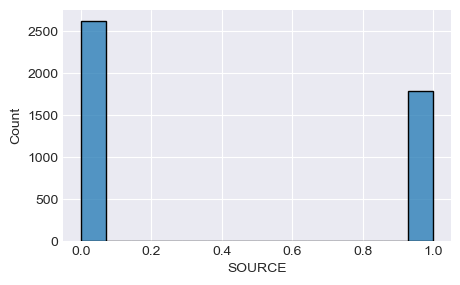

In [7]:
# Target Distribution

plt.figure(figsize = (5,3))
fig = sns.histplot(x = 'SOURCE', data=data)

In [8]:
data.SOURCE.value_counts()

0    2628
1    1784
Name: SOURCE, dtype: int64

In [9]:
data[num_features].describe()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE
count,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000
mean,38.197688,12.741727,4.541260,8.718608,257.524479,28.234701,33.343042,84.612942,46.626473
std,5.974784,2.079903,0.784091,5.049041,113.972365,2.672639,1.228664,6.859101,21.731218
min,13.700000,3.800000,1.480000,1.100000,8.000000,14.900000,26.000000,54.000000,1.000000
25%,34.375000,11.400000,4.040000,5.675000,188.000000,27.200000,32.700000,81.500000,29.000000
50%,38.600000,12.900000,4.570000,7.600000,256.000000,28.700000,33.400000,85.400000,47.000000
75%,42.500000,14.200000,5.050000,10.300000,321.000000,29.800000,34.100000,88.700000,64.000000
max,69.000000,18.900000,7.860000,76.600000,1183.000000,40.800000,39.000000,115.600000,99.000000


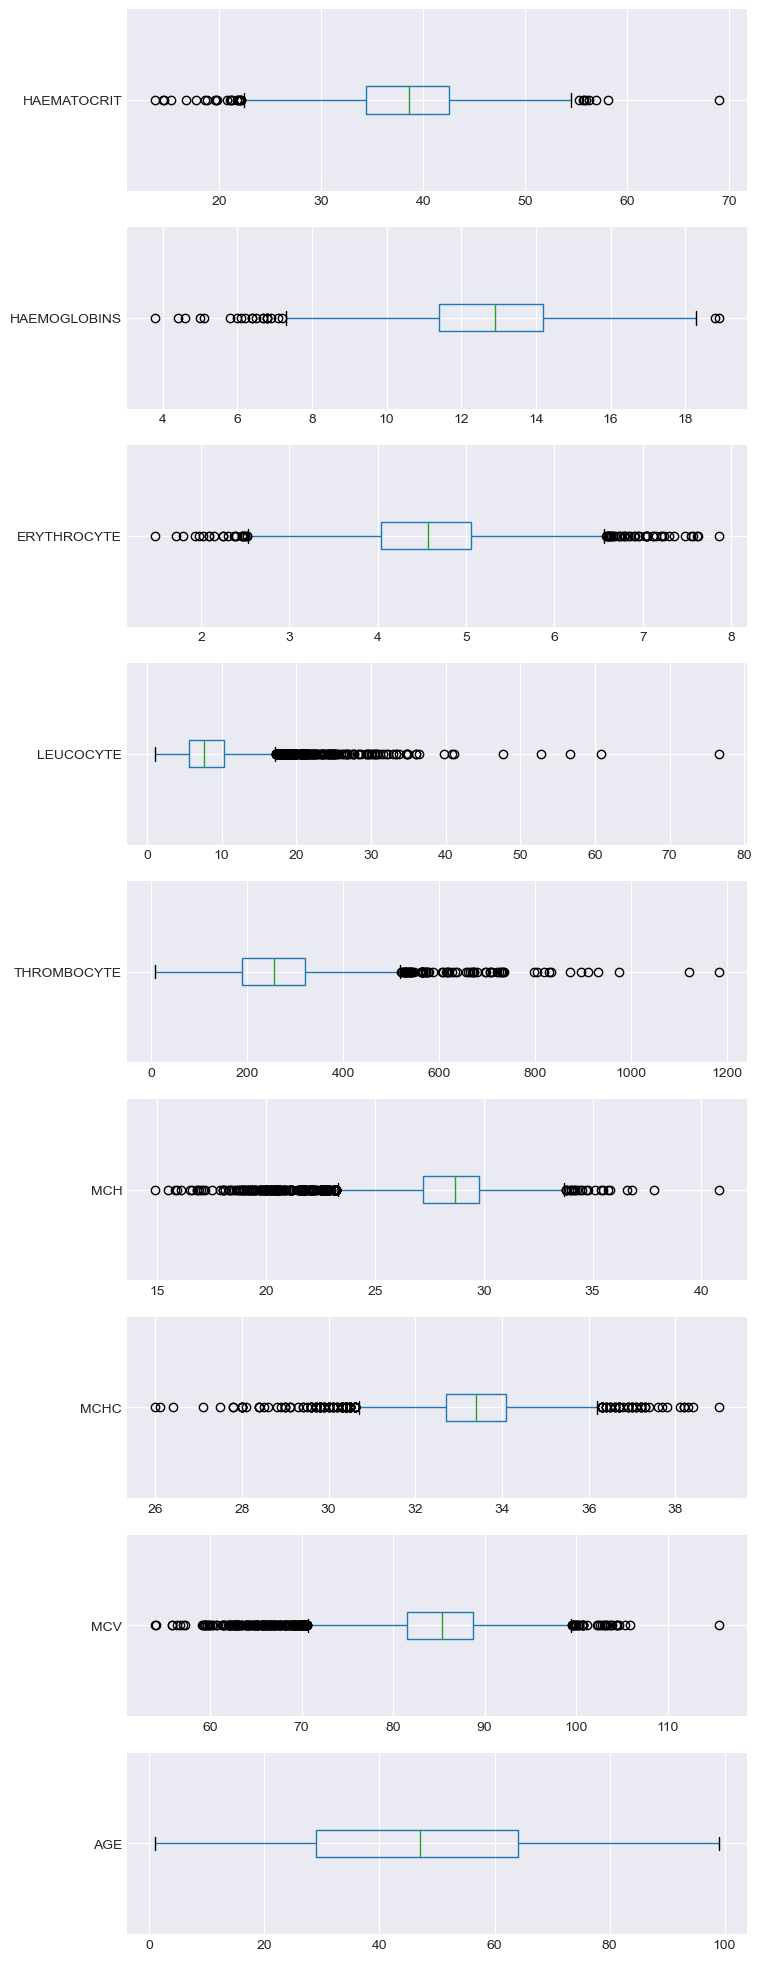

In [10]:
fig, axes = plt.subplots(9,1, figsize=(8, 25))

for i, c in enumerate(num_features):
    f = data[[c]].boxplot(ax=axes[i], vert=False)

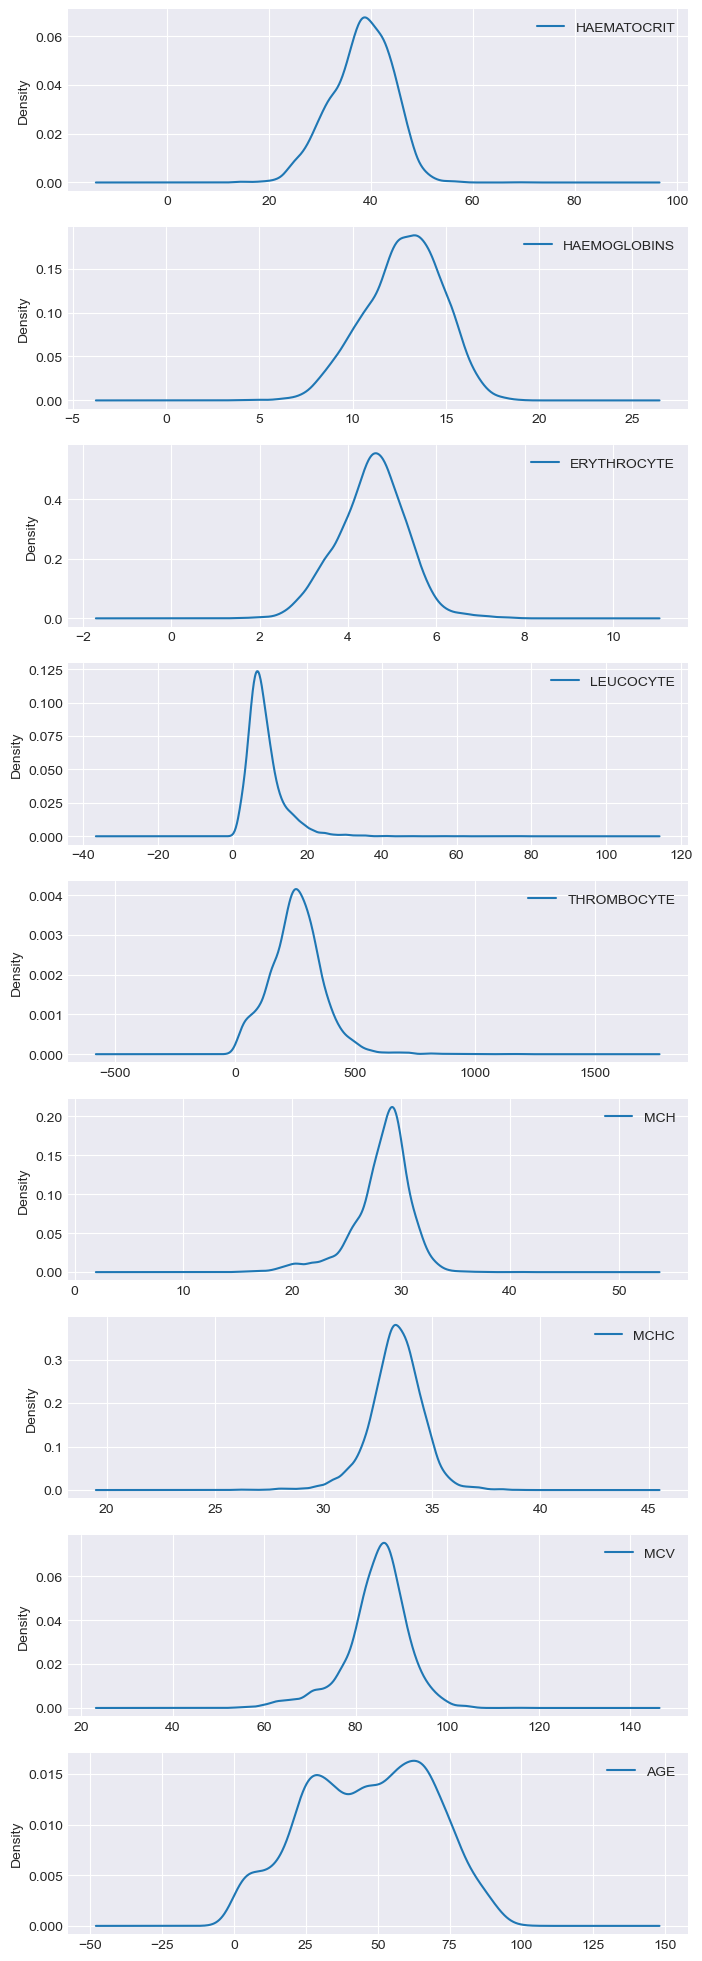

In [11]:
fig, axes = plt.subplots(9, 1, figsize=(8, 25))
for i, c in enumerate(num_features):
    f = data[[c]].plot(kind='kde', ax=axes[i])

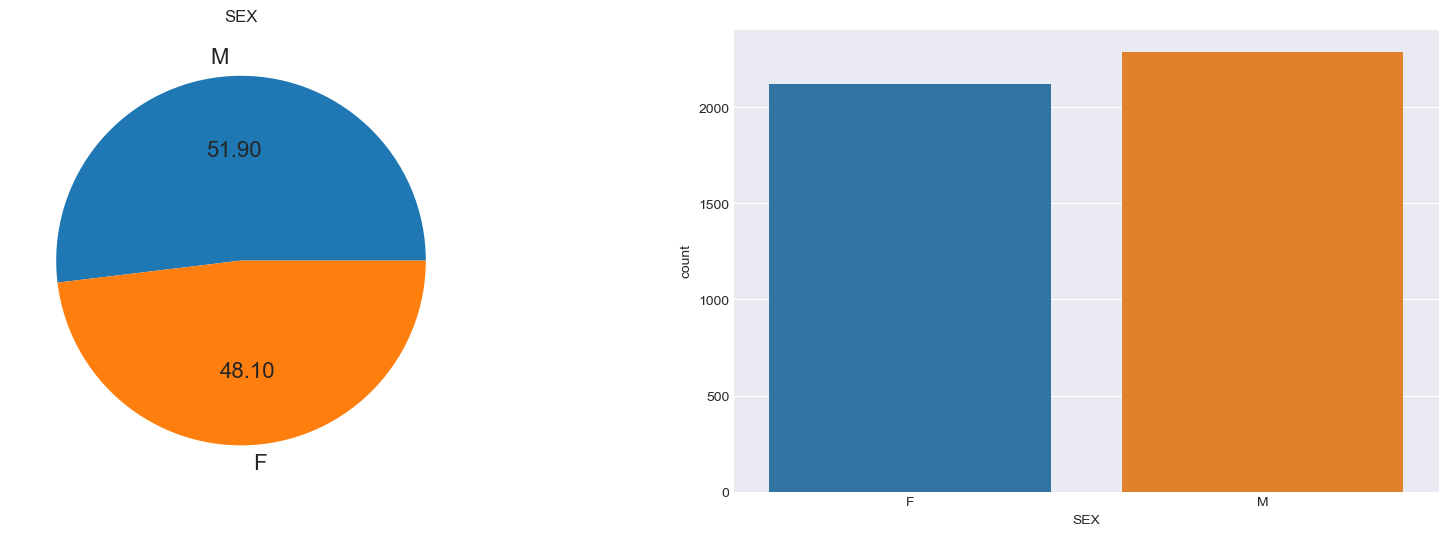

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
df = data['SEX'].value_counts()
barplot = df.plot(kind='pie', ax=axes[0], title='SEX', autopct='%.2f', fontsize=16, ylabel='')
countplot = sns.countplot(x='SEX', data=data, ax=axes[1])

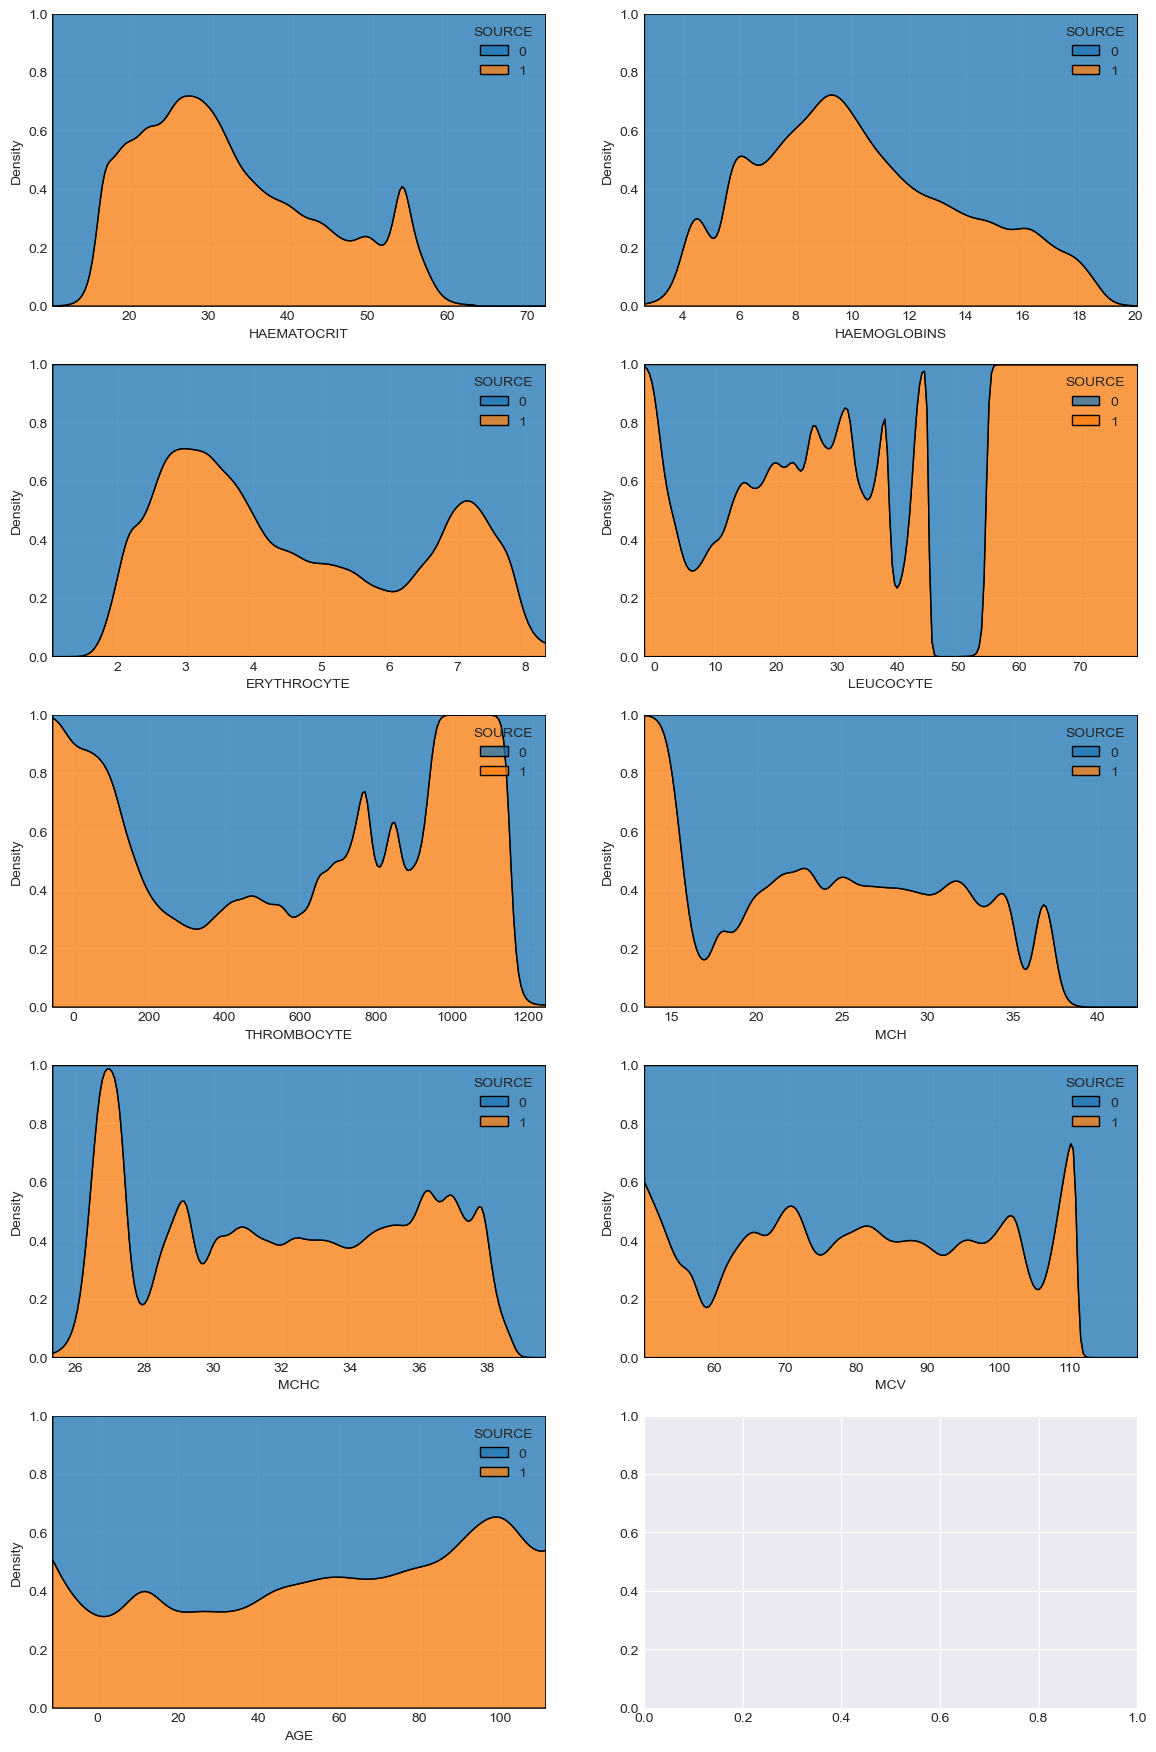

In [13]:
fig, axes = plt.subplots(5,2, figsize=(14,22))
axes = [ax for axes_row in axes for ax in axes_row]
for i,c in enumerate(data[num_features]):
    plot = sns.kdeplot(data=data, x=c, hue='SOURCE', multiple='fill', ax=axes[i])

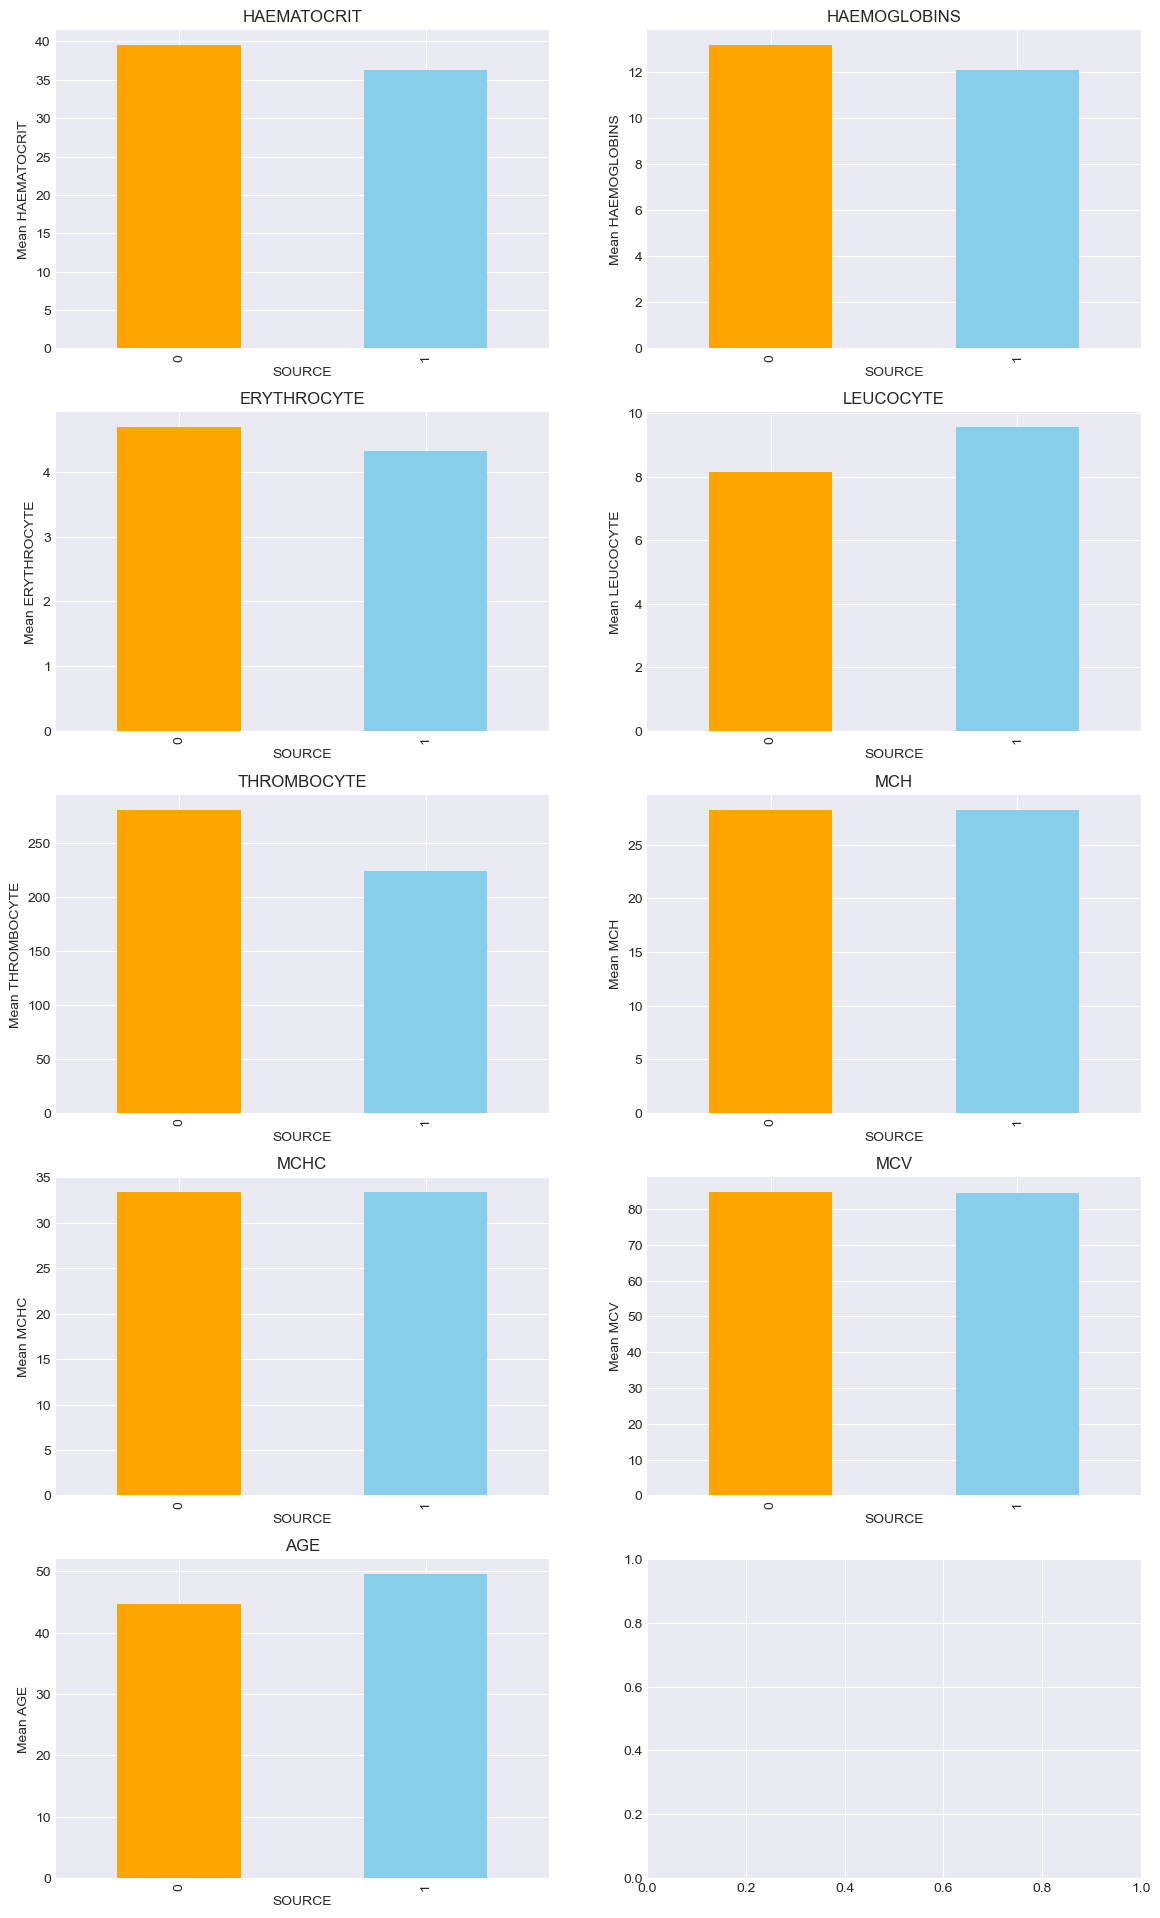

In [14]:
fig, axes = plt.subplots(5,2, figsize=(14,24))
axes = [ax for axes_row in axes for ax in axes_row]
for i,c in enumerate(data[num_features]):
    df = data.groupby("SOURCE")[c].mean()
    plot = df.plot(kind='bar', title=c, ax=axes[i], ylabel=f'Mean {c}', color=('orange','skyblue'))

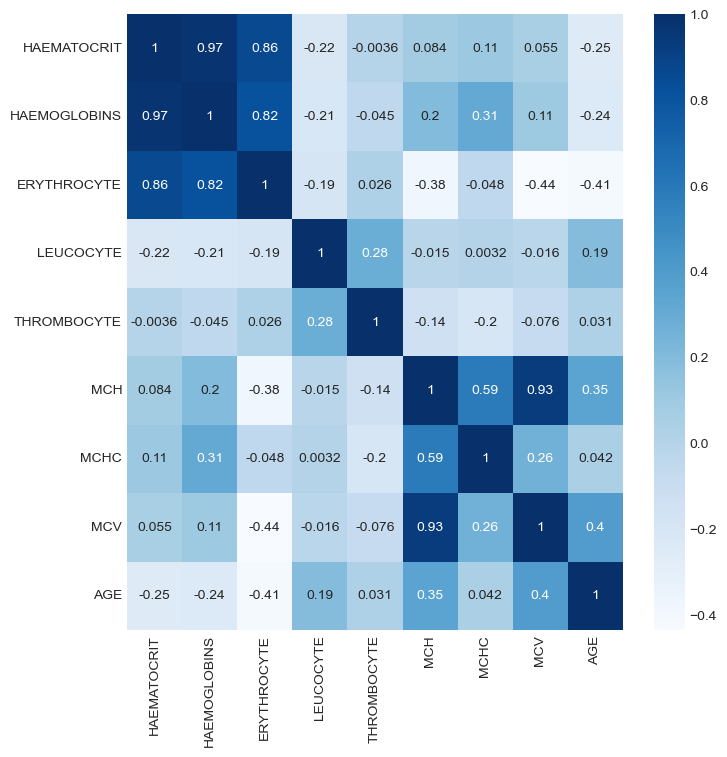

In [15]:
corr_matt = data[num_features].corr(method='pearson')
plt.figure(figsize=(8,8))
corr = sns.heatmap(corr_matt, annot=True, cmap='Blues', cbar='False')

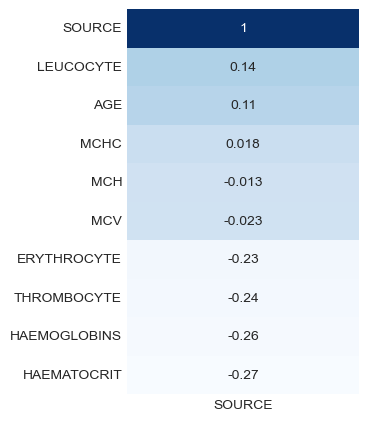

In [16]:
corr_matt = data.corr(method='pearson')[['SOURCE']].sort_values(by='SOURCE', ascending=False)
plt.figure(figsize=(3,5))
corr = sns.heatmap(corr_matt, annot=True, cmap='Blues', cbar=False)

In [17]:
# Leucocyte and Age are positively correlated with target
# while Thrombocyte, Haemoglobins, Haematorcrit are negatively correlated with target

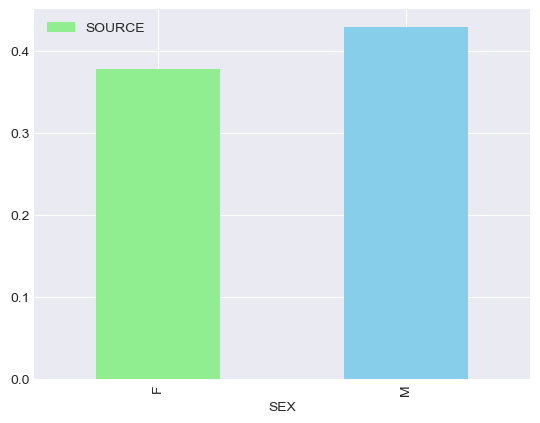

In [18]:
df = data.groupby('SEX')['SOURCE'].mean().to_frame().reset_index()
plot = df.plot(kind='bar', x='SEX', y='SOURCE', color=('lightgreen', 'skyblue'))

In [19]:
# there are more male patients than female patients

In [20]:
#Replacing SEX labels as binary numbers
X_train.SEX.replace({'F':0, 'M':1}, inplace=True)
X_test.SEX.replace({'F':0, 'M':1}, inplace=True)

In [21]:
#Scaling the features to a range of [0,1]

scaler = MinMaxScaler(feature_range=(0,1))

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

X_train.head(5)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX
2902,0.594595,0.675497,0.504702,0.052980,0.139574,0.575290,0.684615,0.508117,0.591837,1
1282,0.373874,0.403974,0.330721,0.213245,0.233191,0.490347,0.515385,0.493506,0.316327,0
2571,0.295045,0.337748,0.329154,0.075497,0.001702,0.386100,0.553846,0.339286,0.540816,0
3702,0.659910,0.701987,0.561129,0.144371,0.010213,0.525097,0.576923,0.503247,0.693878,1
1989,0.790541,0.814570,0.617555,0.031788,0.065532,0.571429,0.538462,0.584416,0.438776,1


In [22]:
#removing least correlated features, 
X_train.drop(['MCH', 'MCHC', 'MCV'], axis=1, inplace=True)
X_test.drop(['MCH', 'MCHC', 'MCV'], axis=1, inplace=True)

X_train.head(5)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,AGE,SEX
2902,0.594595,0.675497,0.504702,0.052980,0.139574,0.591837,1
1282,0.373874,0.403974,0.330721,0.213245,0.233191,0.316327,0
2571,0.295045,0.337748,0.329154,0.075497,0.001702,0.540816,0
3702,0.659910,0.701987,0.561129,0.144371,0.010213,0.693878,1
1989,0.790541,0.814570,0.617555,0.031788,0.065532,0.438776,1


In [23]:
tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, tree.predict(X_train)))
print("Test accuracy : ", accuracy_score(y_test, tree.predict(X_test)))

Train accuracy :  1.0
Test accuracy :  0.681766704416761


In [24]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, logreg.predict(X_train)))
print("Test accuracy : ", accuracy_score(y_test, logreg.predict(X_test)))

Train accuracy :  0.7163502408614338
Test accuracy :  0.7089467723669309


In [25]:
SVC = SVC(random_state=1)

SVC.fit(X_train, y_train)
print("Train accuracy : ", accuracy_score(y_train, SVC.predict(X_train)))
print("Test accuracy : ", accuracy_score(y_test, SVC.predict(X_test)))

Train accuracy :  0.7557381694531029
Test accuracy :  0.7180067950169875


In [26]:
rfc = RandomForestClassifier(random_state=1)

rfc.fit(X_train, y_train)
print("Train accuracy : ", accuracy_score(y_train, rfc.predict(X_train)))
print("Test accuracy : ", accuracy_score(y_test, rfc.predict(X_test)))

Train accuracy :  1.0
Test accuracy :  0.7406568516421291


In [38]:
models = {
    "Logistic Regression": LogisticRegression(),
    "      Decision Tree": DecisionTreeClassifier(),
    "      Random Forest": RandomForestClassifier(),
    "     Neural Network": MLPClassifier(),
    "  Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

Logistic Regression trained.
      Decision Tree trained.
      Random Forest trained.
     Neural Network trained.
  Gradient Boosting trained.


In [39]:
acy =[]
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acy.append(acc)
    print(name + " Accuracy: {:.2f}%".format(acc * 100))

Logistic Regression Accuracy: 70.89%
      Decision Tree Accuracy: 67.50%
      Random Forest Accuracy: 73.95%
     Neural Network Accuracy: 72.03%
  Gradient Boosting Accuracy: 73.27%


<AxesSubplot:>

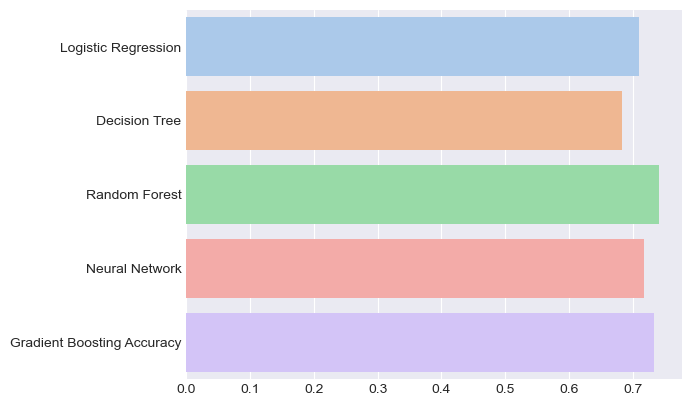

In [37]:
key=['Logistic Regression','Decision Tree','Random Forest','Neural Network','Gradient Boosting Accuracy']
sns.barplot(x = acy, y = key, palette='pastel')